# Getting Started with Eppic
The goal is to help you get started with using PlasmaCalcs to read & manipulate eppic outputs. **_Estimated time: 5 minutes_**

This notebook assumes you have already followed the instructions (see the README at https://gitlab.com/Sevans7/plasmacalcs) to install PlasmaCalcs on your machine.

Recommended: copy this notebook to somewhere on your machine (outside of the PlasmaCalcs package), then go through the cells one at a time!

In [1]:
## imports ##
# builtins
import os   # for os.chdir to navigate to directory where data is stored.
# external packages available via pip install 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PlasmaCalcs package
import PlasmaCalcs as pc


## optional / settings ##
import pdb   # --- after a crash, use pdb.pm() to enter the namespace of the crash, for easy debugging!

plt.rcParams['animation.html']='jshtml'  # enables in-line animations in Jupyter

from IPython.display import display, HTML  # set cell width in Jupyter:
display(HTML("<style>.container { width:90% !important; }</style>"))

# xarray options
xr.set_options(display_expand_data=False,
               keep_attrs=True, # -- keep attrs during operations. Note, doesn't handle conflicts, just takes attrs from the first array.
              );
# matplotlib options
plt.rcParams['savefig.dpi'] = 70
plt.rcParams['figure.dpi'] = 70  # lower dpi for inline plots makes the Jupyter notebook file smaller.
# EDIT THAT DPI^ TO A LARGER NUMBER (e.g., 300, not 70) TO SEE HIGHER-RES IN-LINE PLOTS!

# matplotlib animation options (you might need to use these lines in order to save mp4 files!)
# import matplotlib.animation as animation
# import matplotlib
# matplotlib.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [2]:
# force reload the PlasmaCalcs package.
#   Useful if you've made any changes but don't want to restart kernel.
#   Not required; you can delete this line if you are never editing PlasmaCalcs.
pc = pc.reload(pc)

# Basics

In [5]:
## create an EppicCalculator object, from example data ##
# create an EppicCalculator based on the example in tests/test_eppic/test_eppic_tinybox
#   this calculator will know how to load & compute various values based on the available snapshots.
EPPIC_TINYBOX_DIR = pc.pc_path('tests', 'test_eppic', 'test_eppic_tinybox')
print(EPPIC_TINYBOX_DIR)
print(pc.pc_path()) # path to the palsmacalcs directory
with pc.InDir(EPPIC_TINYBOX_DIR):  # temporarily cd into that directory ^
    ec = pc.EppicCalculator.from_here(u_t=1, kw_units=dict(M=1))  # u_t=1 & M=1 <--> SI units for time & mass
    #here, you can also provide u_l (length), u_n (number density), and ne_si (electron number density)
    #eppic.i is the default filename in the from_here method

# note: to use your own data, just os.chdir() into the directory with your eppic.i file instead!
# show the representation of the EppicCalculator (customized to contain relevant information!)
ec

/Users/tessgoodman/codepackages/plasmacalcs/tests/test_eppic/test_eppic_tinybox
/Users/tessgoodman/codepackages/plasmacalcs


EppicCalculator(input_deck=EppicInputDeck(with 3 distributions, filename='/Users/tessgoodman/codepackages/plasmacalcs/tests/test_eppic/test_eppic_tinybox/eppic.i'), dims=DimRegion(snap=SnapList(len=10; Snap('2560', 0), ..., Snap('25600', 9)), fluid=EppicDistList(EppicDist('e-', 0), EppicDist('H+', 1), EppicDist('C+', 2)), jfluid=EppicNeutral('neutral', 0), component=ComponentList(Component('x', 0), Component('y', 1), Component('z', 2))))

In [8]:
# you can call the EppicCalculator as if it were a function, to load or compute a quantity.
ec('B')  # magnetic field  (Bx=By=0, Bz=0.001 here. eppic B is constant in space & time.)

<xarray.DataArray 'B' (component: 3)> Size: 24B
0.0 0.0 0.001
Coordinates:
  * component  (component) object 24B x y z
Attributes:
    units:    si

In [9]:
ec('E') #electric field
# eppic B only varies across vector component ('x', 'y', 'z'), so the result only had a 'component' dimension.
# but E varies across vector component, space, and time, so the result has 'component', 'x', 'y', and 'snap' dimensions.

<xarray.DataArray 'E' (component: 3, snap: 10, x: 16, y: 16)> Size: 61kB
2.612 2.045 2.512 2.977 3.216 2.348 1.769 2.038 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * component  (component) object 24B x y z
  * x          (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y          (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap       (snap) object 80B 2560 5120 7680 10240 ... 20480 23040 25600
    t          (snap) float64 80B 3.84e-05 7.68e-05 ... 0.0003456 0.000384
Attributes:
    units:    si

In [10]:
# meanwhile, fluid quanitites (n, u, T, nusj) vary across, well, fluid!
# n (number density) varies across fluid, space, and time:
ec('n')

<xarray.DataArray 'n' (fluid: 3, snap: 10, x: 16, y: 16)> Size: 61kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 5.915e+10 5.874e+10 6.013e+10
Coordinates:
  * fluid    (fluid) object 24B e- H+ C+
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap     (snap) object 80B 2560 5120 7680 10240 ... 17920 20480 23040 25600
    t        (snap) float64 80B 3.84e-05 7.68e-05 ... 0.0003456 0.000384
Attributes:
    units:    si

In [11]:
#you can specify what components you want outputted like this:
ec('n', fluid = 'e-')

<xarray.DataArray 'n' (snap: 10, x: 16, y: 16)> Size: 20kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.544e+11 3.547e+11 3.442e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap     (snap) object 80B 2560 5120 7680 10240 ... 17920 20480 23040 25600
    t        (snap) float64 80B 3.84e-05 7.68e-05 ... 0.0003456 0.000384
Attributes:
    units:    si

In [12]:
#lets say I want only the first snapshot:
ec('n', fluid= 'e-', snap = 0)

<xarray.DataArray 'n' (x: 16, y: 16)> Size: 2kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.501e+11 3.659e+11 3.745e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
    snap     object 8B 2560
    t        float64 8B 3.84e-05
Attributes:
    units:    si

In [13]:
#similarly, T (temperature) varies across fluid, space, and time:
ec('T')

<xarray.DataArray 'T' (fluid: 3, snap: 10, x: 16, y: 16)> Size: 61kB
7.419e+03 7.133e+03 7.243e+03 7.227e+03 ... 4.813e+03 4.93e+03 4.926e+03
Coordinates:
  * fluid    (fluid) object 24B e- H+ C+
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap     (snap) object 80B 2560 5120 7680 10240 ... 17920 20480 23040 25600
    t        (snap) float64 80B 3.84e-05 7.68e-05 ... 0.0003456 0.000384
Attributes:
    units:    si

In [14]:
# u (velocity) varies across component, fluid, space, and time:
ec('u')

<xarray.DataArray 'u' (snap: 10, fluid: 3, component: 3, x: 16, y: 16)> Size: 184kB
-8.022e+03 -4.704e+03 -1.368e+03 -1.233e+04 ... -13.35 2.972 -10.34 -12.48
Coordinates:
  * x          (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y          (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap       (snap) object 80B 2560 5120 7680 10240 ... 20480 23040 25600
    t          (snap) float64 80B 3.84e-05 7.68e-05 ... 0.0003456 0.000384
  * fluid      (fluid) object 24B e- H+ C+
  * component  (component) object 24B x y z
Attributes:
    units:    si

In [15]:
# there are many options, for example:
ec('B', component='z')  # get only the z component of B

<xarray.DataArray 'B' ()> Size: 8B
0.001
Coordinates:
    component  object 8B z
Attributes:
    units:    si

In [14]:
# note, to get the underlying numpy array (or scalar value), use .values or .item():
print(ec('B').values)
print(ec('B', component='z').item())

[0.    0.    0.001]
0.001


# Plotting

### Plotting images via xarray built-in methods...
...is always an option, but you might prefer to use PlasmaCalcs methods instead; see next subsection for examples.

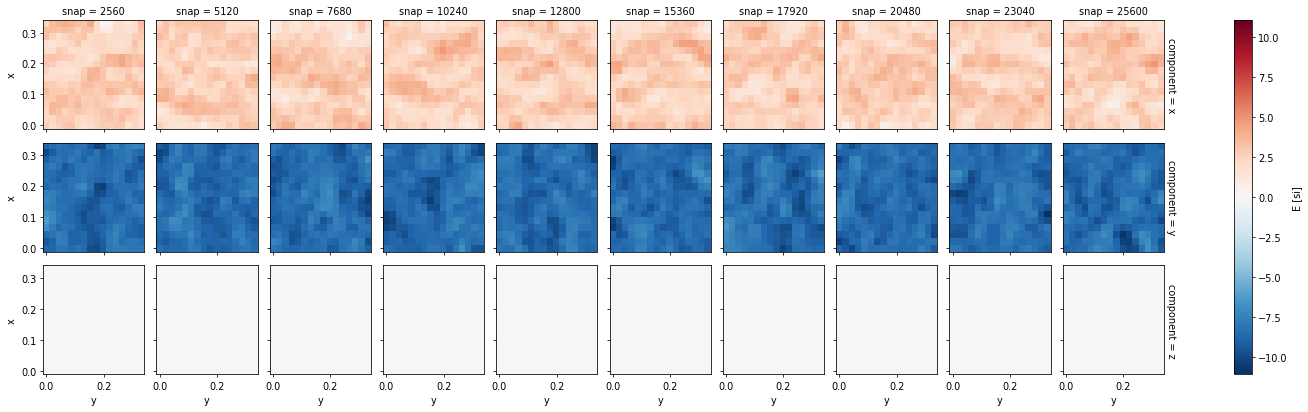

In [6]:
E = ec('E')
E.plot(row='component', col='snap', size=2)

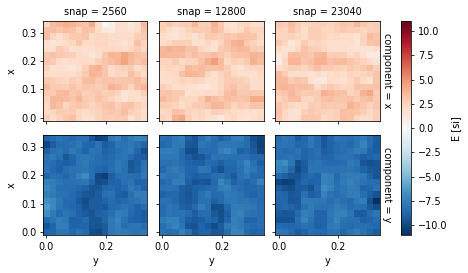

In [17]:
# Let's only keep every 4th snapshot, and keep only the 'x' and 'y' components:
E = ec('E')
E_sliced = E.isel(component=[0,1], snap=slice(None, None, 4))
E_sliced.plot(row='component', col='snap', size=2)
#using built in python slice function: slice(start, stop, step)

In [18]:
# [EFF] note: if you only care about a subset of the data,
# you can save computer time & memory by only computing results in the regions you care about!
# see "Indexing, Slicing, Selecting Dimpoints" below in this notebook, for more details.
E_subset = ec('E', component=['x', 'y'], snap=slice(None, None, 4))  # loads only at these components & snaps
print(E_subset.identical(E_sliced))  # results identical to the less efficient method from the previous cell.

True


### Plotting images via PlasmaCalcs methods
does some nice things by default, and also makes it super easy to make animations!

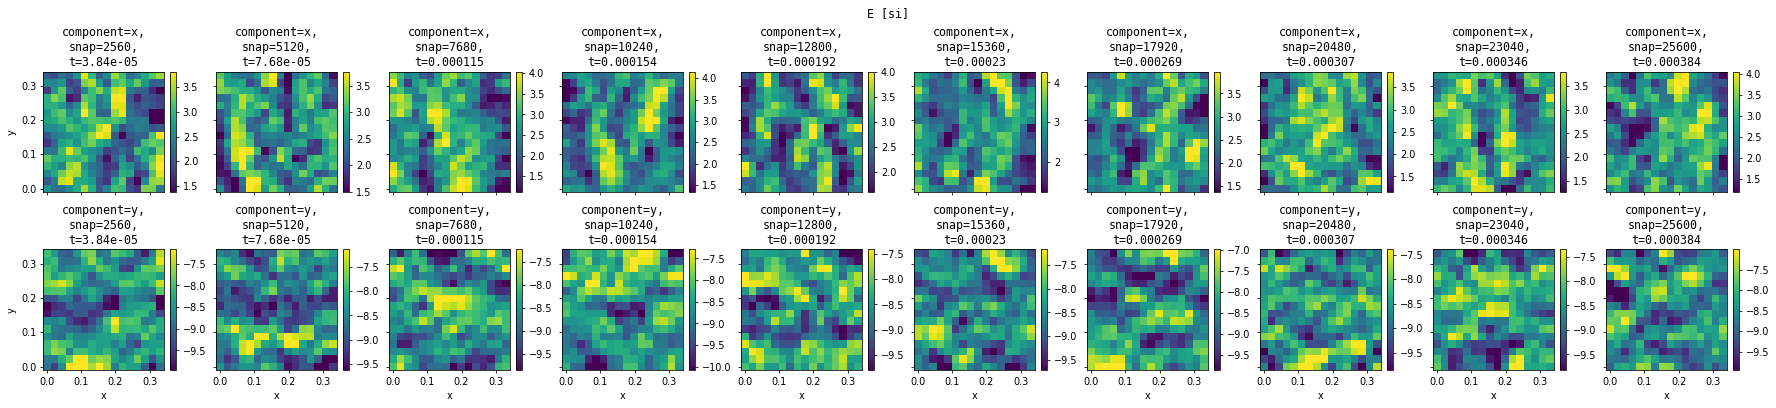

In [20]:
E = ec('E', component=['x', 'y'])  # z component is boring, see previous section for details.
E.pc.subplots(row='snap', col='component'); #note the order of row and col is reversed compared to xarray plotting call
#row: dimension to plot ACROSS rows
#col: dimension to plot DOWN cols

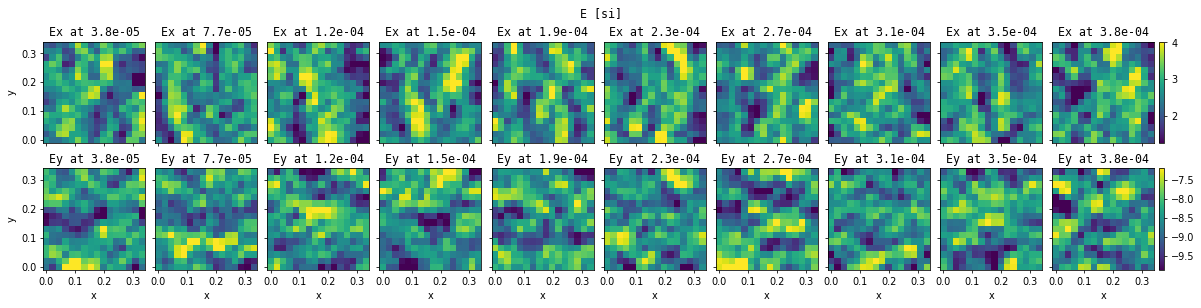

In [ ]:
# you can also specify some things to change the behavior:
E.pc.subplots(row='snap', col='component',
              axsize=(1.5,1.5),  # make each subplot smaller (default (2,2))
              share_vlims='row',  # use same vmin & vmax across each row. Options: False, 'row', 'col', 'all'
              title='E{component} at {t:.1e}',  # customize the subplot titles
              #.1e gives 1 decimal place, .2e gives 2
             );
# the ; is a trick so it doesnt print unwanted return statements, leaves only the plots

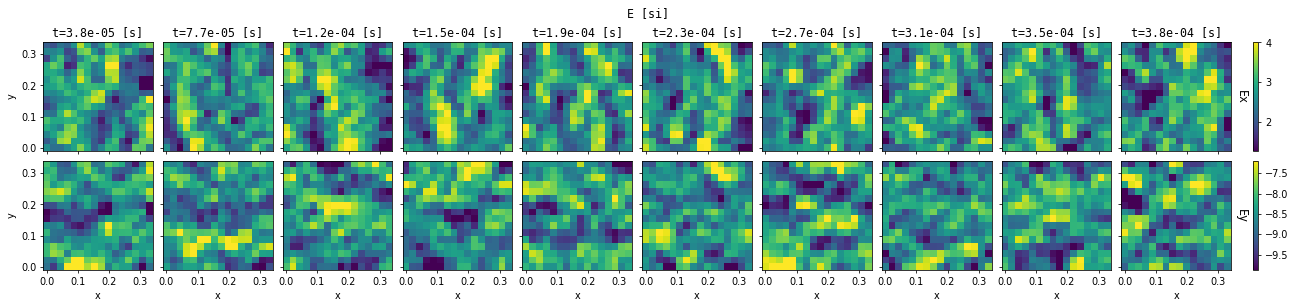

In [22]:
# alternate labeling scheme:
E.pc.subplots(row='snap', col='component', axsize=(1.5,1.5), share_vlims='row',
              rtitle='E{component}', ttitle='t={t:.1e} [s]',
             );
#rtitle: rightmost column title
#ttitle: topmost row title

### Animations using PlasmaCalcs

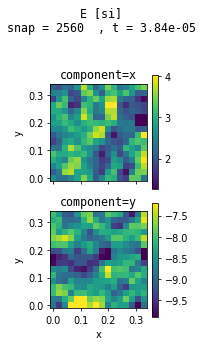

In [32]:
# if your array has more dimensions than can be plotted from what you specified,
# PlasmaCalcs tries to infer a time dimension and assumes you want to make an animation.
# (you could also specify the time dimension with t='snap')
# the code here only plots a static version, at E.isel(snap=0)
E.pc.subplots(col='component');  # t info is now in the suptitle.
#suptitle: super title (main header)

In [ ]:
# To make animation inline, use:
E.pc.subplots(col='component').ani()

In [35]:
# To save animation to file, use:
E.pc.subplots(col='component').save('eppic_movie_example')  # or, provide any other filename you want

Completed "movie at '/Users/tessgoodman/codepackages/plasmacalcs/examples/eppic_movie_example.mp4'" in 4.25 seconds!

'/Users/tessgoodman/codepackages/plasmacalcs/examples/eppic_movie_example.mp4'

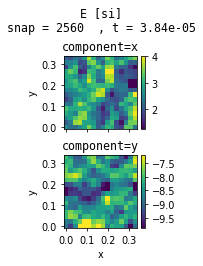

In [36]:
# sometimes the default matplotlib spacing is ugly or cuts off.
# It would be nice if it didn't do that... but it's tricky to fix in general.
# You can fix it "by-hand" by playing around with options: hspace, wspace, top, bottom, left, right.
E.pc.subplots(col='component',
              top=1.3,  # played around with this to reduce space between suptitle and plots
              left=0.2, # played around with this to prevent left & right ends of suptitle from getting cut off
             );

#In Matplotlib, wspace is a parameter used to control the horizontal spacing between subplots within a figure. 
#hspace controls vertical spacing

### Plotting lines via PlasmaCalcs methods

In [37]:
# (optional) let's first tell ec "stop outputting z component, by default", since we know z is not very interesting:
ec.component = ['x', 'y']
# (you can restore previous behavior via ec.component=ec.components, or equivalently, ec.component=None.)

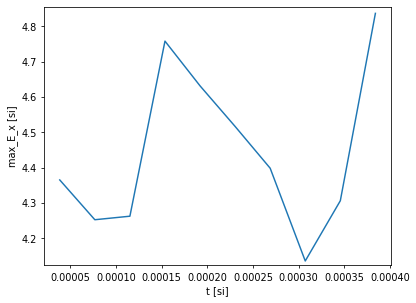

In [38]:
# making a line plot of value versus time
max_E = ec('max_E_x')  # equivalent: ec('E_x').max(('x', 'y'))
max_E.pc.timelines()

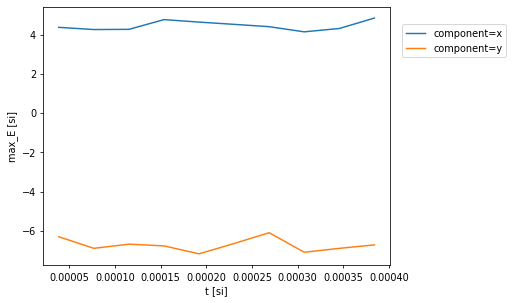

In [39]:
# can also handle multiple lines at once.
max_E = ec('max_E')  # equivalent: ec('E').max(('x', 'y'))
max_E.pc.timelines();

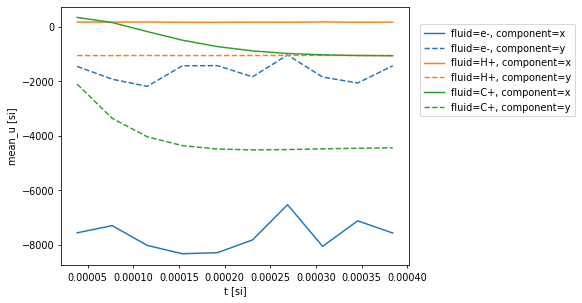

In [40]:
# can even handle 2 dims' worth of lines - u varies across fluid AND component!
mean_u = ec('mean_u')  # equivalent: ec('u').mean(('x', 'y'))
mean_u.pc.timelines();

In [ ]:
# if you want a movie of a line, use .pc.line() instead. Use pc.lines() for multiple lines.
# remember animation code: E.pc.subplots(col='component').ani()
E_at_x0 = ec('E', slices=dict(x=0))
E_at_x0.pc.lines().ani()

### PlasmaCalculator built-in plotters

--- XarraySubplots([depth=0, height=3, size=9], 'deltafrac_n') ---

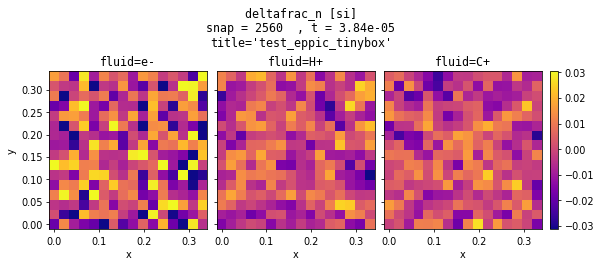

In [12]:
# eppic calculator (and other PlasmaCalculator objects) have a few built-in plotters.
#   - Especially useful for initial exploration of the data, to make lots of plots with minimal effort.
#   - Less useful for making "publication-quality" plots or making customized plots.
# use ec.plot(plotname) to call one of them.
# use help(ec.get_plotters) to help with searching options.

# to plot the fractional density perturbation for all fluids at the current snap:
ec.plot('deltafrac_n')

# roughly equivalent to:
# ec('deltafrac_n', extra_coords={'title': ec.title}).pc.subplots(cmap='plasma', row='fluid', share_vlims='all')

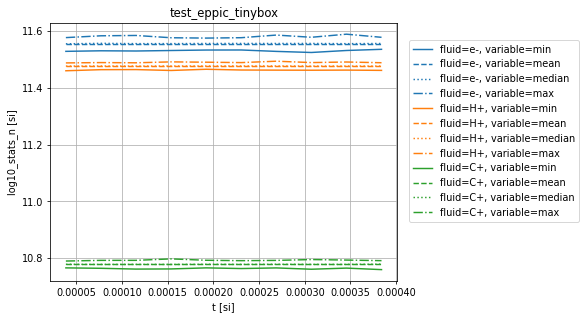

In [10]:
#this lets you visualize number density statistics of each fluid
ec.plot('n_stats')

# roughly equivalent to:
# ec('log10_stats_n', extra_coords={'title': ec.title})[['min', 'mean', 'median', 'max']].pc.timelines(dims=['fluid', 'variable'])

### ADVANCED: Customizing plots with PlasmaCalcs methods

--- XarrayLines([depth=0, height=1, size=5], 'E') ---

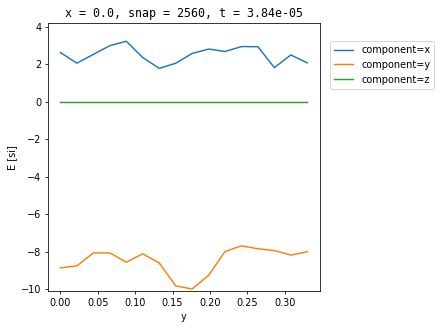

In [38]:
# You can create custom combinations of plots and still animate them if you want.
# PlasmaCalcs animation-friendly plot objects are stored as trees,
#  with root.ani() looping across frames and telling all children to loop across frames too.
# For example, the pc.lines() tree has one XarrayLine node for each line, and one XarrayText node for the title.
E_at_x0 = ec('E', slices=dict(x=0))
xlines = E_at_x0.pc.lines()
xlines

In [ ]:
# you can add custom text that will update in time:
xlines = E_at_x0.pc.lines()
text_obj = plt.text(x=0.1, y=-5, s='my note; snap={snap}')
text_node = E_at_x0.pc.text(text_obj)
xlines.add_child(text_node)  # tell xlines to update text_node too, when doing xlines.ani()
# in practice, you can easily do this in fewer lines, e.g.:
# xlines.add_child(E_at_x0.pc.text(plt.text(x=0.1, y=-5, s='my note; snap={snap}')))
xlines.ani()  # will include note at x=0.1, y=5 (in data coordinates), updating with {snap} each frame.

--- MovieOrganizerNode([depth=0, height=2, size=5], 'mymovie') ---

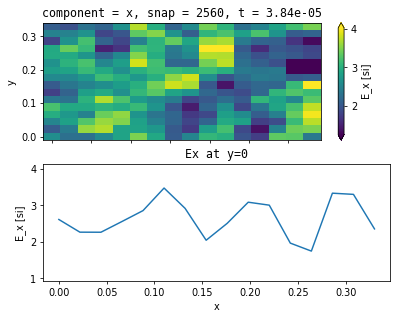

In [35]:
# you can also create your subplot grid from scratch, if you want more complicated combinations of plots:
Ex = ec('E_x')  # varies across snap, x, y
Ex_at_y0 = Ex.isel(y=0)  # varies across snap, x
fig, axs = plt.subplots(nrows=2, ncols=1,
                        squeeze=False,  # keep axs as a 2D array. (optional)
                       )
movie = pc.MovieOrganizerNode('mymovie')  # root node for movie. Not directly associated with any plot.

# top plot
plt.sca(axs[0,0])
image_node = Ex.pc.image(aspect='auto')  # aspect='auto' --> don't rescale axes. [TODO] colorbar messes with alignment...
axs[0,0].set(xticklabels=[], xlabel='')  # remove xticklabels from top plot
movie.add_child(image_node)

# bottom plot
plt.sca(axs[1,0])
line_node = Ex_at_y0.pc.line(title='Ex at y=0')
movie.add_child(line_node)

movie  # use movie.ani() or movie.save() to animate & save the results.

# Learning which quantities & options exist
Now you know how to get values and how to plot things.  
But which values can you actually get, and what other options do you have?

In [15]:
# which quantities are available???
# how else can I use this calculator object???
# which other options are available??
# --- See ec.help() for help! ---
ec.help()

- obj('qname') or obj.get('qname') --> get the value of quantity qname.

- obj.help(str) shows help for all related quantities:
    - obj.help('') --> help with all available quantities.
    - obj.help(str) --> get help with all quantities related to that str:
        - quantities containing str
        - quantities from module with name matching str

    - obj.help(str, 'VARS') --> help with only KNOWN_VARS.
    - obj.help(str, 'PATTERNS') --> help with only KNOWN_PATTERNS.
    - obj.help(str, 'TREE') --> only show help for quantities in match_var_tree(str).
    - obj.help(str, ..., tree=True) --> include help for ALL quantities in match_var_tree(str),
        instead of ignoring tree nodes which have any LoadableVar ancestors.

    - obj.help(str, ..., modules=True) --> include module info in the output;
        this helps with understanding where the code for each quantity is defined.

- EppicCalculator.cls_help(str) works similarly, but:
    - doesn't require creating an instance o

In [17]:
#how can I get information related to keyword options?
ec.help_call_options()

Showing self.help_call_options(): docs for keys from self.kw_call_options()
---------------------------------------------------------------------------
'E_un0_mode': mode for calculating E_un0, the electric field in the neutral frame, where u_n=0.
    None, 'un=u', 'un=0', 'E0_perpB', 'E0_perpmodB', or 'E0_perpmodB_min'.
    None --> E_un0 = E + u_n x B. (i.e., E & u_n in "lab frame" then transform to u_n=0 frame.)
    'un=u' --> E_un0 = E + u x B. (i.e., assume un==u; transform to the u=0 frame.)
                [EFF] if self.has_var('E_u0'), use E_un0 = self('E_u0') directly, without getting u;
                    assumes self('E_u0') provides "E without the u x B contribution".
                    If E_u0 not available, this mode requires 'u' to not vary with fluid.
    'un=0' --> E_un0 = E. (i.e., assume un==0 already; no need to shift frames.)
    'E0_perpB' --> E_un0 = E0_un0_perpB. (i.e., E perp to B in u_n=0 frame,
                assuming zeroth order equilibrium velocities fr

In [25]:
# example of using help(). (Use '' instead of 'E' to see all options.)
ec.help('E')  # gives options related to electric field.

Showing help for related KNOWN_VARS: ['E', 'E_un0', 'E_ext', 'E_phi', 'E_un0_type', 'E_un0_perpmod_B', 'E_un0_perpmag_B', 'tfbi_E_thresh']

'E':
    electric field. E = E_external + E_phi = E_external - grad(phi)

'E_un0':
    E_un0 = electric field in the neutral frame, where u_n=0.
    Result depends on self.E_un0_mode; see help(type(self).E_un0_mode) for details.

'E_ext':
    external electric field. (directly from Eppic).

'E_phi':
    electric field, from phi. E_phi = -grad(phi). Doesn't include E_ext component.

'E_un0_type':
    string telling method that will be used to get E_un0. Based on self.E_un0_mode.
    possible results:
        'nan' <--> will crash. (e.g. this occurs if E_un0_mode = 'E0_perpmodB_min')
        'E+unxB' <--> self('E') + self('u_neutral_cross_B')
        'E_u0' <--> self('E_u0')
        'E+uxB' <--> self('E') + self('u_cross_B')
        'E' <--> self('E')
        'E0_perpB' <--> self('E0_un0_perpB')

'E_un0_perpmod_B':
    E_un0_perpmod_B == |E_un0 perp 

In [26]:
# example of using help_call_options. (use '' instead of 'fft' to see all options.)
ec.help_call_options('fft')

Showing self.help_call_options(): docs for keys from self.kw_call_options()
Only showing keys containing search='fft'
---------------------------------------------------------------------------
'fft_dims': the dims over which to possibly apply fft (FFTLoader methods).
    will only apply fft along these dims for an array if they actually appear in the array.
    None --> use self.maindims. (this is the default.)
    See also: self.fft_dims_for(array).

'fft_half': alias to self.fft_slices.half

'fft_keep': alias to self.fft_slices.keep

'fft_slices': the dict of indexers to apply to all fft results from self, by default.
    keys can be a pre-fft or post-fft dimension name,
        e.g. 'x' or 'freq_x' both lead to slicing of the result's 'freq_x' dimension.
        (note if rad=True it would be 'k_x' in the result, and 'x' would apply but not 'freq_x'.)
        all other keys (not a pre-fft or post-fft dimension name) are ignored.
    values can be slice, int, iterable, or non-integer

# Indexing, Slicing, Selecting Dimpoints

##### See slicing_tutorial for a more comprehensive tutorial on slicing!

In [48]:
#you can slice an eppiccalculator object to analyze specific sections
#for example to get every other x-coordinate:
ec('n', fluid = 'e-', slices={'x' : slice(None, None, 2)}, snap = 0)

<xarray.DataArray 'n' (x: 8, y: 16)> Size: 1kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.704e+11 3.707e+11 3.515e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 64B 0.0 0.044 0.088 0.132 0.176 0.22 0.264 0.308
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
    snap     object 8B 2560
    t        float64 8B 3.84e-05
Attributes:
    units:    si

In [49]:
#or every other snapshot:
ec('n', fluid = 'e-', snap = slice(None, None, 2))

<xarray.DataArray 'n' (snap: 5, x: 16, y: 16)> Size: 10kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.644e+11 3.651e+11 3.609e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap     (snap) object 40B 2560 7680 12800 17920 23040
    t        (snap) float64 40B 3.84e-05 0.0001152 0.000192 0.0002688 0.0003456
Attributes:
    units:    si

In [50]:
#you can also use the xarray .isel method to select certain indexes
E = ec('E')
E_sliced = E.isel(component=[0,1], snap=slice(None, None, 4))
E_sliced

<xarray.DataArray 'E' (component: 2, snap: 3, x: 16, y: 16)> Size: 12kB
2.612 2.045 2.512 2.977 3.216 2.348 ... -8.393 -8.056 -7.818 -8.519 -9.091
Coordinates:
  * component  (component) object 16B x y
  * x          (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y          (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * snap       (snap) object 24B 2560 12800 23040
    t          (snap) float64 24B 3.84e-05 0.000192 0.0003456
Attributes:
    units:    si

In [59]:
# dimpoint is a dictionary of values representing a single point in dimension-space
# to see the first value of all included dimensions, use:
dp = ec.get_first_dimpoint()
print(dp)

#to show all included dimensions:
dp.keys()

DimPoint(snap=Snap('2560', 0), fluid=EppicDist('e-', 0), jfluid=EppicNeutral('neutral', 0), component=Component('x', 0))


dict_keys(['snap', 'fluid', 'jfluid', 'component'])

In [44]:
#to unpack the dp dictionary and pass in its contents as keyword arguments, use **
ec('n', **dp)

<xarray.DataArray 'n' (x: 16, y: 16)> Size: 2kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.501e+11 3.659e+11 3.745e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
    snap     object 8B 2560
    t        float64 8B 3.84e-05
Attributes:
    units:    si

In [60]:
#this is a longer method but is useful if you only want to apply dp to certain dimensions and not others

first_snap = dp['snap']
first_fluid = dp['fluid']
first_jfluid = dp['jfluid']
first_component = dp['component']

In [61]:
ec('n', snap= first_snap, fluid= first_fluid, jfluid= first_jfluid, component= first_component )

<xarray.DataArray 'n' (x: 16, y: 16)> Size: 2kB
3.532e+11 3.604e+11 3.585e+11 3.641e+11 ... 3.501e+11 3.659e+11 3.745e+11
Coordinates:
    fluid    object 8B e-
  * x        (x) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
  * y        (y) float64 128B 0.0 0.022 0.044 0.066 ... 0.264 0.286 0.308 0.33
    snap     object 8B 2560
    t        float64 8B 3.84e-05
Attributes:
    units:    si

In [62]:
#check that this is true:
np.all(ec('n', **dp)) == np.all(ec('n', snap= first_snap, fluid= first_fluid, jfluid= first_jfluid, component= first_component ))

<xarray.DataArray 'n' ()> Size: 1B
True
Coordinates:
    fluid    object 8B e-
    snap     object 8B 2560
    t        float64 8B 3.84e-05
Attributes:
    units:    si